# Deep Dive | Computer Vision

This notebook provides an introduction to basic and intermediate Computer Vision concepts. Developed in July 2021 for BWSI Racecar.

## 0.0 Image Formation

In [28]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


In [29]:
path = "alpine.jpg"
#pull in an image
img = cv.imread(path)

In [30]:
def show_image(image, size = 8) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.figure(figsize=(size, size), dpi=100)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

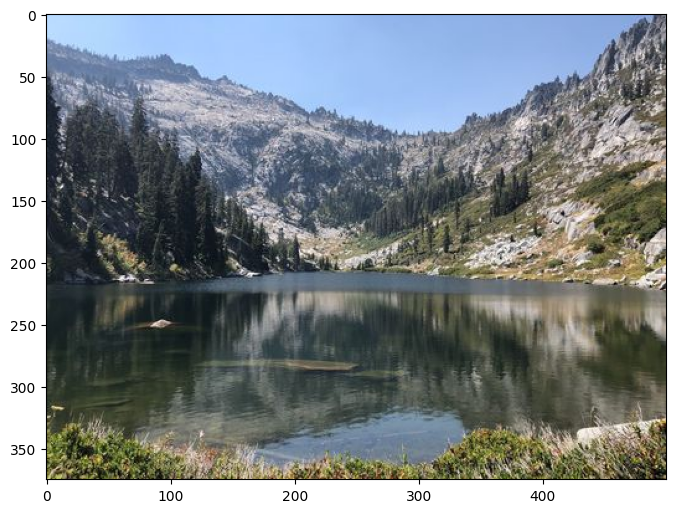

In [31]:
show_image(img)

## 1.0 Image Processing with Point Operations
Let's try applying some simple pointwise operations to the image, starting with increasing brightness and contrast.

In [32]:
def adjust_brightness_contrast(sample_image,brightness_adjustment=0.0, contrast_factor=1.0):
    image = np.copy(sample_image)
    image = np.multiply(image,contrast_factor)
    image += brightness_adjustment
    image = np.clip(image,0,255).astype(np.uint8)
    return image

Play around with the brightness and contrast values until you find a combination that looks good to you!

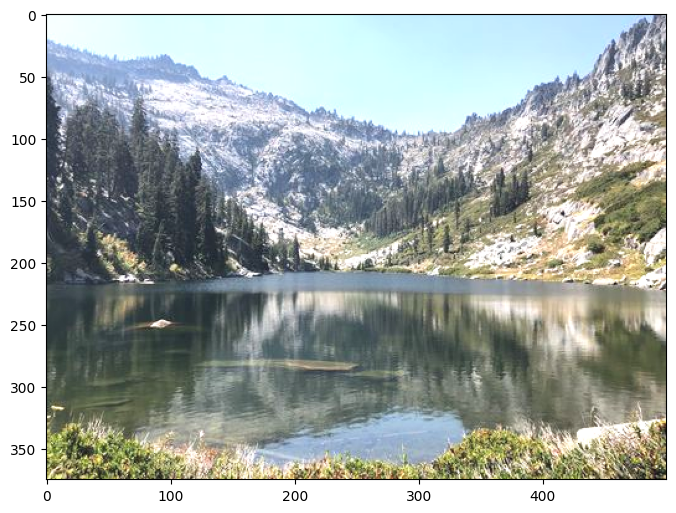

In [51]:
brightness = 20
contrast = 1.23
adjusted_image = adjust_brightness_contrast(img,brightness,contrast)
show_image(adjusted_image)

The following function implements histogram equalization on our image. Do you notice any differences

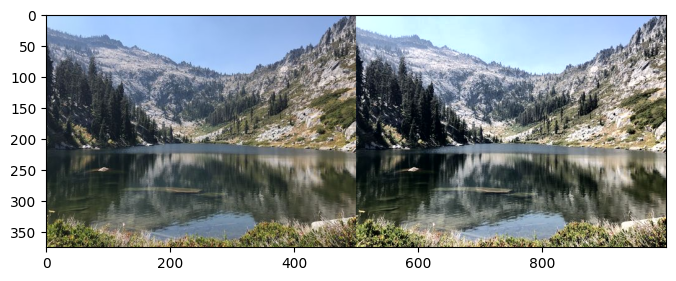

In [52]:
def hisEqulColor(image_in):
    img = np.copy(image_in)
    ycrcb=cv.cvtColor(img,cv.COLOR_BGR2YCR_CB)
    channels=cv.split(ycrcb)
    cv.equalizeHist(channels[0],channels[0])
    cv.merge(channels,ycrcb)
    cv.cvtColor(ycrcb,cv.COLOR_YCR_CB2BGR,img)
    return img

equ = hisEqulColor(img)
res = np.hstack((img,equ)) #stacking images side-by-side, with original image on the left and eq on right
show_image(res)

## 2.0 Image Processing with Neighborhood Operations

Let's load in a different image to take a look at the effects of neighborhood operations.

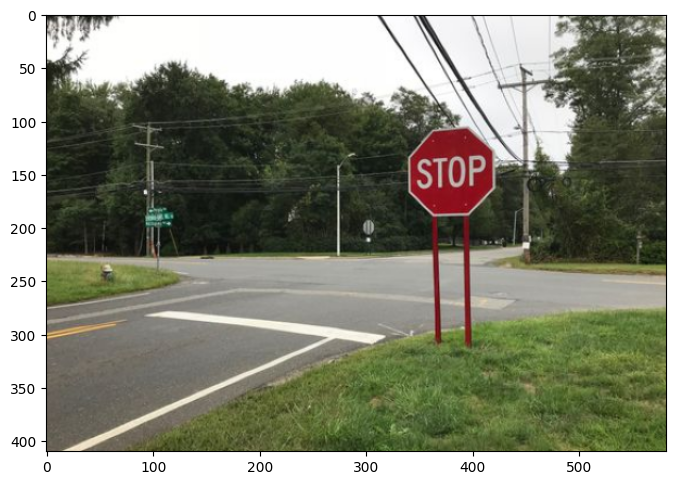

In [53]:
path = "stop.png"
#pull in an image
img = cv.imread(path)
show_image(img)

### 2.1 Linear Filters

The following function will apply kernels

In [178]:
def show_kernels_subplots(img):
    #TODO apply a box blur to the image and store it in box_img
    box_kernel = np.array([[1,1,1],
                           [1,1,1],
                           [1,1,1]])
    box_img = cv.filter2D(img,-1,box_kernel * 1/9)
    
    #TODO apply a gaussian blur to the image and store it in gauss_img
    gauss_kernel = np.array([[1,2,1],
                            [2,4,2],
                            [1,2,1]])
    gauss_img = cv.filter2D(img,-1,gauss_kernel * 1/16)
    
    #apply a sharpen kernel to the image and store it in sharp_img
    sharp_kernel = np.array([[0,-1,0],
                            [-1,5,-1],
                            [0,-1,0]])
    sharp_img = cv.filter2D(img,-1,sharp_kernel)
    
    #TODO apply a laplacian kernel to the image and store it in lap_img
    lap_kernel = np.array([[0,-1,0],
                           [-1,4,-1],
                           [0,-1,0]])
    lap_img = cv.filter2D(img,-1,lap_kernel)
    
    #TODO apply a sobel_x kernel to the image and store it in sobx_img
    sobx_kernel = np.array([[-1,0,1],
                           [-2,0,2],
                           [-1,0,1]])
    sobx_img = cv.filter2D(img,-1,sobx_kernel)
    
    #TODO apply a sobel_y kernel to the image and store it in soby_img
    soby_kernel = np.array([[1,2,1],
                           [0,0,0],
                           [-1,-2,-1]])
    soby_img = cv.filter2D(img,-1,soby_kernel)
    
    fig, ( (ax1,ax2,ax3), (ax4,ax5,ax6) ) = plt.subplots(2, 3,figsize=(15,6))  
    ax1.set_title("Box Blurred Image")
    ax1.imshow(cv.cvtColor(box_img, cv.COLOR_BGR2RGB))
    ax2.set_title("Gaussian Blurred Image")
    ax2.imshow(cv.cvtColor(gauss_img, cv.COLOR_BGR2RGB))
    ax3.set_title("Sharpened Image")
    ax3.imshow(cv.cvtColor(sharp_img, cv.COLOR_BGR2RGB))
    ax4.set_title("Laplacian Image")
    ax4.imshow(cv.cvtColor(lap_img, cv.COLOR_BGR2RGB))
    ax5.set_title("Sobel X Image")
    ax5.imshow(cv.cvtColor(sobx_img, cv.COLOR_BGR2RGB))
    ax6.set_title("Sobel Y Image")
    ax6.imshow(cv.cvtColor(soby_img, cv.COLOR_BGR2RGB))
    plt.show()
    

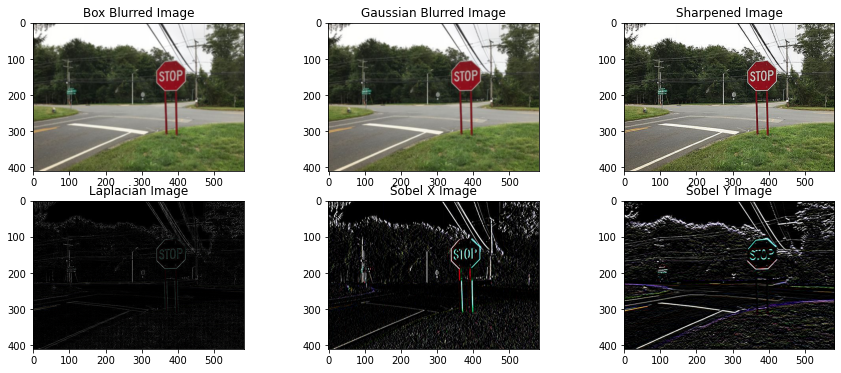

In [179]:
show_kernels_subplots(img)

### 2.2 Non-Linear Filters

Use the documentation on [cv.bilateralFilter](https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed) and [cv.medianBlur](https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9) to apply these two filters to the image. Try tweaking the kernel size for medianBlur, what kernel size do we lose the texture of the road but maintain the characters on the stop sign? For the bilateral filter, start with the sigmaColor and sigmaSpace values at 10 each. Keep them matching, but try adjusting this value up and down. How does the image change when the sigma values are very large? very small?

In [105]:
def show_non_linear_subplots(img):
    #TODO apply a median filtering to our image
    med_img = cv.medianBlur(img,7)
    
    #TODO apply a bilateral filtering to our image
    bilat_img = cv.bilateralFilter(img,15,100,100)
    
    
    
    fig, ( (ax1,ax2)) = plt.subplots(1, 2,figsize=(15,6))  
    ax1.set_title("Median Filtered Image")
    ax1.imshow(cv.cvtColor(med_img, cv.COLOR_BGR2RGB))
    ax2.set_title("Bilateral Filtered Image")
    ax2.imshow(cv.cvtColor(bilat_img, cv.COLOR_BGR2RGB))
    plt.show()

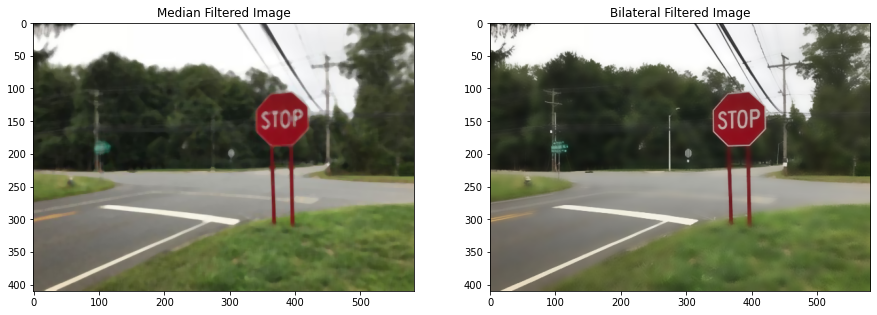

In [106]:
show_non_linear_subplots(img)

#### 2.2.1 Binary Image Morphological Operations
Let's continue with our stop sign image, and try to mask out just the octagon using morphological operations.

First we need to grab just the red pixels:

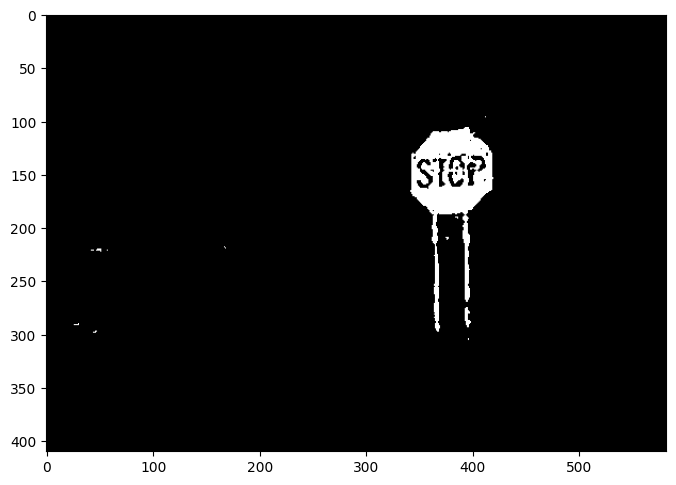

In [108]:
result = img.copy()
image = cv.cvtColor(img, cv.COLOR_BGR2HSV)
red_lower_hsv = np.array([155,25,0])
red_upper_hsv = np.array([179,255,255])
red = cv.inRange(image, red_lower_hsv, red_upper_hsv)

show_image(red)

The following function showcases all of the morphology operations available to us. Take a look at the outputs. 

In [109]:
def show_morph_ops(img,kernel_size):
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    erosion = cv.erode(red,kernel,iterations = 1)
    dilation = cv.dilate(red,kernel,iterations = 1)
    opening = cv.morphologyEx(red, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(red, cv.MORPH_CLOSE, kernel)
    
    fig, ( (ax1,ax2,ax3,ax4)) = plt.subplots(1, 4,figsize=(15,6))  
    ax1.set_title("Eroded Image")
    ax1.imshow(cv.cvtColor(erosion, cv.COLOR_BGR2RGB))
    ax2.set_title("Dilated Image")
    ax2.imshow(cv.cvtColor(dilation, cv.COLOR_BGR2RGB))
    ax3.set_title("Opened Image")
    ax3.imshow(cv.cvtColor(opening, cv.COLOR_BGR2RGB))
    ax4.set_title("Closed Image")
    ax4.imshow(cv.cvtColor(closing, cv.COLOR_BGR2RGB))
    plt.show()


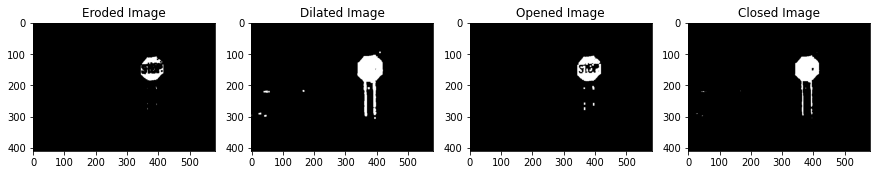

In [110]:
show_morph_ops(img,5)

Now it's your turn, try to combine morph operations to extract just the octagon, without the legs or any background noise.

In [204]:
def get_stop_sign(img,kernel_size):
    #TODO: combine morph operations to extract just the octagon, and store this mask in output_mask
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    dilation = cv.dilate(red,kernel,iterations = 1)
    eroded = cv.erode(dilation,kernel,iterations = 2)
    close = cv.morphologyEx(eroded, cv.MORPH_CLOSE, kernel)
    output_mask = cv.morphologyEx(close, cv.MORPH_OPEN, kernel)
    
    fig, ( (ax1,ax2, ax3)) = plt.subplots(1, 3,figsize=(15,6))  
    ax1.set_title("Original Image")
    ax1.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax2.set_title("Generated Mask")
    ax2.imshow(cv.cvtColor(output_mask, cv.COLOR_BGR2RGB))
    ax3.set_title("Masked Image")
    ax3.imshow(cv.cvtColor(cv.bitwise_and(img, img, mask=output_mask), cv.COLOR_BGR2RGB))
    plt.show()

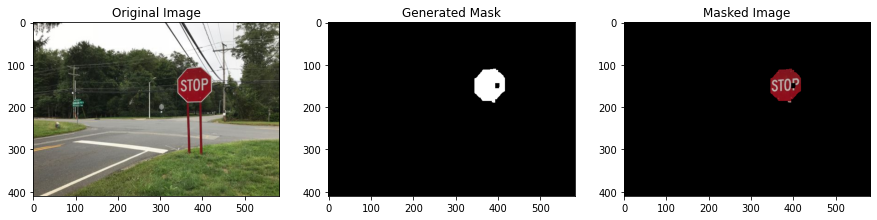

In [205]:
get_stop_sign(img,5)

How does your solution perform? What do you like about it, and what do you want to improve?

## 3.0 Feature Detection & Matching

Use the [OpenCV tutorial](https://docs.opencv.org/4.5.2/d1/d89/tutorial_py_orb.html) to generate keypoints for your stop sign image and the stop sign tile in this directory.

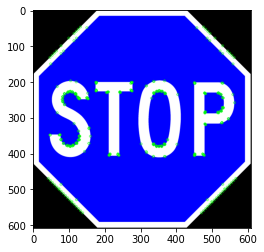

(<matplotlib.image.AxesImage at 0x7ff2f46d3b80>, None)

In [220]:
#TODO generate keypoints for the stop sign image
img2 = cv.imread("stop_tile.png")
orb = cv.ORB_create()

kp = orb.detect(img2,None)

kp, des = orb.compute(img2,kp)

img2 = cv.drawKeypoints(img2, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

Use this [OpenCV tutorial](https://docs.opencv.org/4.5.2/dc/dc3/tutorial_py_matcher.html) to try to match the keypoints in the tile to the image. How does it perform?

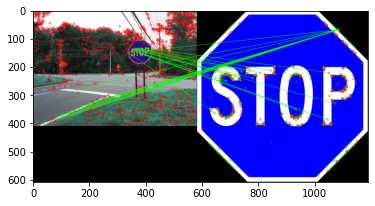

(<matplotlib.image.AxesImage at 0x7ff2f4461640>, None)

In [235]:
#TODO match keypoints from stop sign tile to stop sign image
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()